**<center>* Assignment 18: FORECASTING *</center>**

DATASCIENCE

name: GUVVALA SOMASEKHAR REDDY

mail: showmove5697@gmail.com

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Problem-1)

**Forecast the CocaCola prices data set. Prepare a document for each model explaining** 

**How many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.**


#Solution:

In [ ]:
#Data loading
from google.colab import files
uploaded=files.upload()

Saving CocaCola_Sales_Rawdata.xlsx to CocaCola_Sales_Rawdata (1).xlsx


In [ ]:
cola_sales=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
cola_sales

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


##Basic & EDA

In [ ]:
cola_sales.shape

(42, 2)

In [ ]:
cola_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


* Datatypes of all features are correct.

In [ ]:
cola_sales.nunique()

Quarter    42
Sales      42
dtype: int64

In [ ]:
cola_sales.isna().sum()

Quarter    0
Sales      0
dtype: int64

*  There are no null values in the given dataset. 

In [ ]:
cola_sales.duplicated().value_counts()

False    42
dtype: int64

*  There are no duplicate records in the given dataset. 

In [ ]:
cola_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [ ]:
cola_sales['Quarter_Year'] = cola_sales['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
cola_sales['Date'] = (pd.to_datetime(cola_sales['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
cola_sales['Quarters'] =cola_sales.Quarter.str[:2] 
cola_sales.head()

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1


In [ ]:
cola_sales=cola_sales.drop(['Quarter','Quarter_Year'],axis=1)
cola_sales.head()

,Sales,Date,Quarters
0,1734.827000,1986-01-01,Q1
1,2244.960999,1986-04-01,Q2
2,2533.804993,1986-07-01,Q3
3,2154.962997,1986-10-01,Q4
4,1547.818996,1987-01-01,Q1


In [ ]:
cola_sales["Date"] = pd.to_datetime(cola_sales.Date,format="%b-%y")
cola_sales["month"] = cola_sales.Date.dt.strftime("%b") # month 
cola_sales["year"] = pd.to_numeric(cola_sales.Date.dt.strftime("%Y")) # year 
cola_sales.set_index('Date',inplace=True)
cola_sales.head()

,Sales,Quarters,month,year
Date,,,,
1986-01-01,1734.827000,Q1,Jan,1986
1986-04-01,2244.960999,Q2,Apr,1986
1986-07-01,2533.804993,Q3,Jul,1986
1986-10-01,2154.962997,Q4,Oct,1986
1987-01-01,1547.818996,Q1,Jan,1987


In [ ]:
upsampled_month = cola_sales['Sales']
upsampled_month = upsampled_month.resample('M').mean()
pd.set_option('display.max_rows', 10)
upsampled_month

Date
1986-01-31    1734.827000
1986-02-28            NaN
1986-03-31            NaN
1986-04-30    2244.960999
1986-05-31            NaN
                 ...     
1995-12-31            NaN
1996-01-31    4194.000000
1996-02-29            NaN
1996-03-31            NaN
1996-04-30    5253.000000
Freq: M, Name: Sales, Length: 124, dtype: float64

In [ ]:
interpolated_month = upsampled_month.interpolate(method='linear')
interpolated_month=pd.DataFrame(interpolated_month)
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [ ]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month 
interpolated_month["year"] =pd.to_numeric( interpolated_month.Date.dt.strftime("%Y")) # year
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola_upsp = pd.concat([interpolated_month,months],axis=1)
cocacola_upsp['log_sales'] = np.log(cocacola_upsp['Sales'])
cocacola_upsp


,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


In [ ]:
cocacola_upsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       124 non-null    datetime64[ns]
 1   Sales      124 non-null    float64       
 2   t          124 non-null    int64         
 3   t_squared  124 non-null    int64         
 4   month      124 non-null    object        
 5   year       124 non-null    int64         
 6   Jan        124 non-null    uint8         
 7   Feb        124 non-null    uint8         
 8   Mar        124 non-null    uint8         
 9   Apr        124 non-null    uint8         
 10  May        124 non-null    uint8         
 11  Jun        124 non-null    uint8         
 12  Jul        124 non-null    uint8         
 13  Aug        124 non-null    uint8         
 14  Sep        124 non-null    uint8         
 15  Oct        124 non-null    uint8         
 16  Nov        124 non-null    uint8         
 1

##Visualizing Data Points

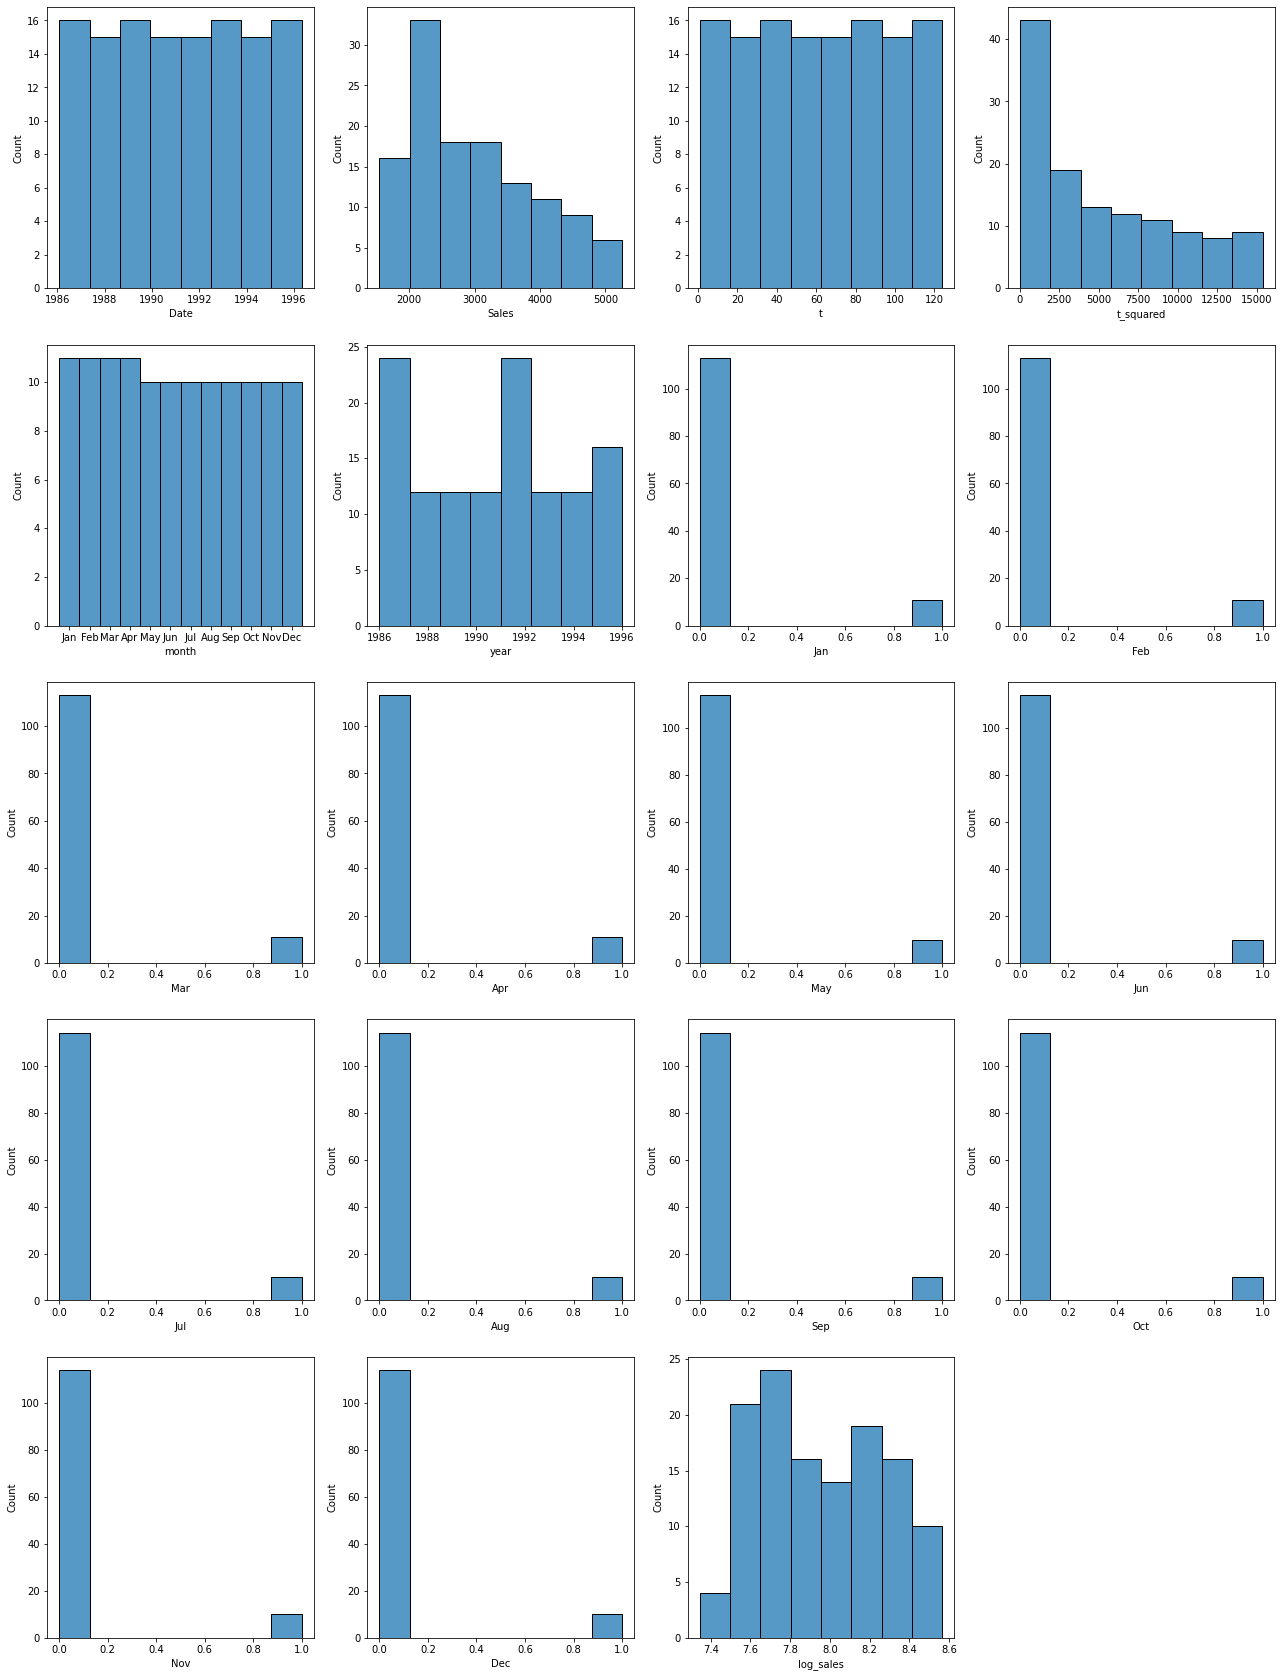

In [ ]:
#plotting histplots to observe datapoints nature
plt.figure(figsize=(22,30))
for i, column in enumerate(cocacola_upsp.columns, 1):
    plt.subplot(5,4,i)
    sns.histplot(cocacola_upsp[column])

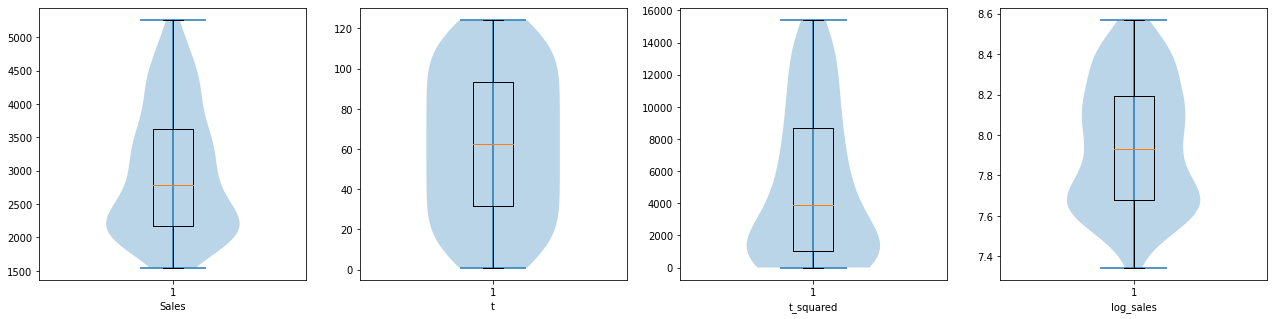

In [ ]:
#plotting boxplots to observe datapoints nature
plt.figure(figsize=(22,5))
for i, column in enumerate(['Sales','t','t_squared','log_sales'], 1):
    plt.subplot(1,4,i)
    plt.violinplot(cocacola_upsp[column])
    plt.boxplot(cocacola_upsp[column])
    plt.xlabel(cocacola_upsp[column].name)

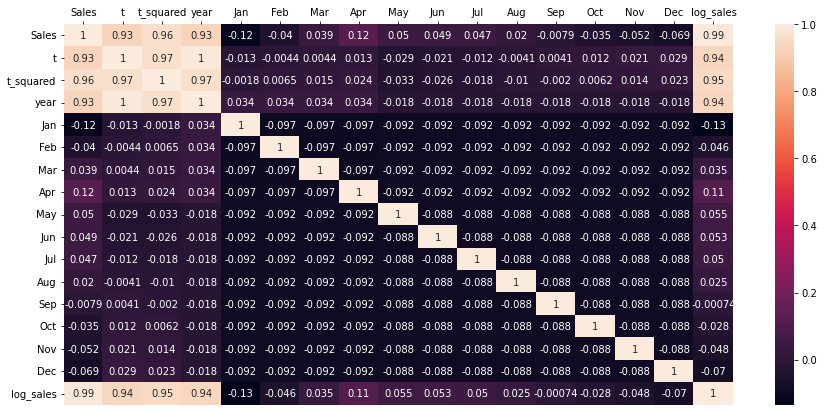

In [ ]:
#plotting the heatmap for correlation
plt.figure(figsize=(15,7))
ax = sns.heatmap(cocacola_upsp.corr(), annot=True)
ax.xaxis.tick_top()

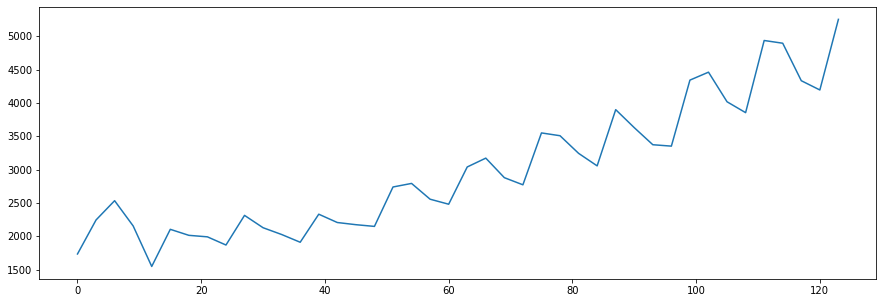

In [ ]:
cocacola_upsp['Sales'].plot(figsize=(15, 5))
plt.show()

**Moving Average** 

In [ ]:
cocacola_upsp.set_index('Date',inplace=True)
cocacola_upsp.head()

,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
Date,,,,,,,,,,,,,,,,,,
1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437


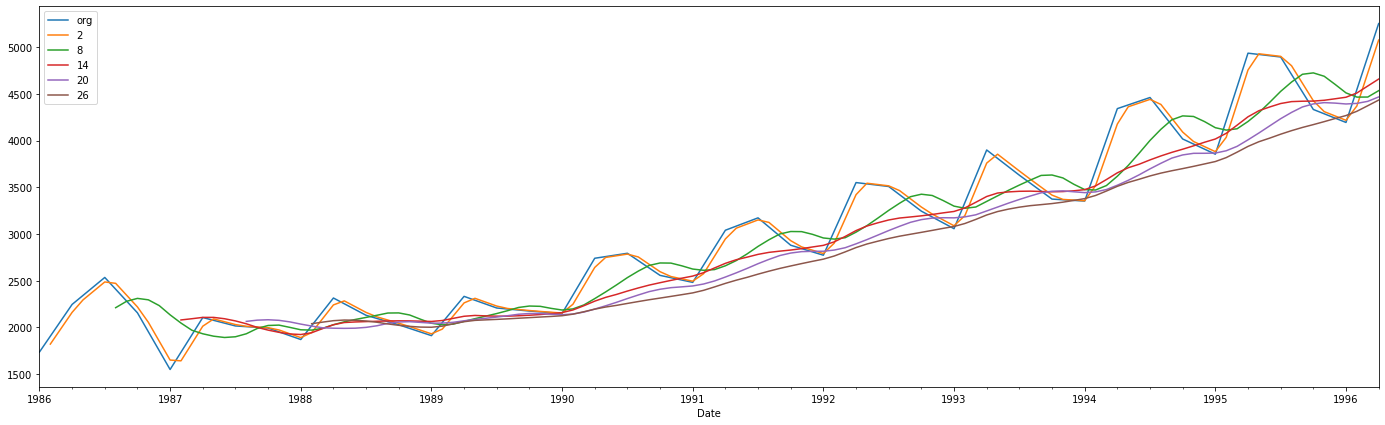

In [ ]:
plt.figure(figsize=(24,7))
cola_sales.Sales.plot(label="org")
for i in range(2,30,6):
    cocacola_upsp['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

**Time series decomposition plot**


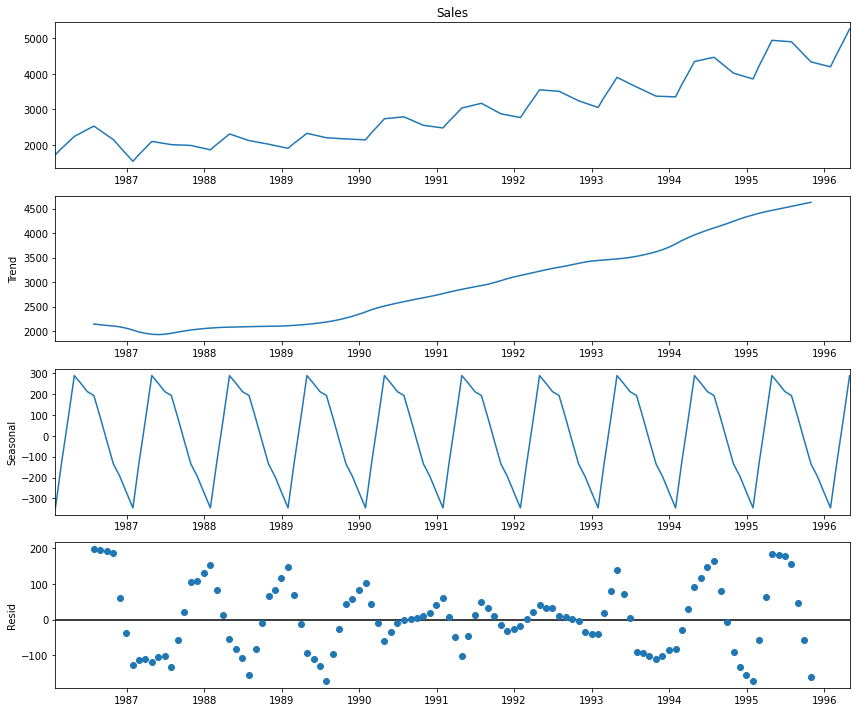

In [ ]:
decompose_ts_add = seasonal_decompose(cocacola_upsp.Sales,freq= 12)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

**ACF plots and PACF plots**

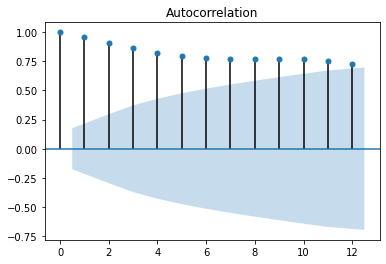

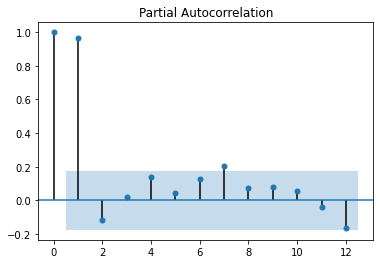

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(cocacola_upsp.Sales,lags=12)
tsa_plots.plot_pacf(cocacola_upsp.Sales,lags=12)
plt.show()

##Splitting data

In [ ]:
cocacola_upsp.shape

(124, 18)

In [ ]:
Train=cocacola_upsp.head(112)
Test=cocacola_upsp.tail(12)

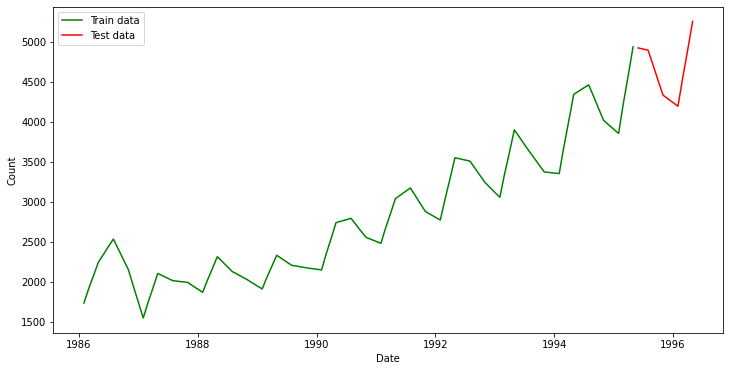

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(Train.Sales, 'green', label='Train data')
plt.plot(Test.Sales, 'red', label='Test data')
plt.legend()
plt.show()

##Forecasting_Data_Driven_Models

**Evaluation Metric MAPE**

In [ ]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

**Simple Exponential Method**

In [ ]:
from sklearn.metrics import mean_squared_error
ses_model = SimpleExpSmoothing(Train['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(12)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,Test.Sales))
train_rmse_ses = np.sqrt(mean_squared_error(train_pred_ses,Train.Sales))
mape_ses = MAPE(test_pred_ses,Test.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 7.816879349714216 
 Train Root Mean Squared Error = 138.77744259150316 
 Test Root Mean Squared Error  = 436.621529823947


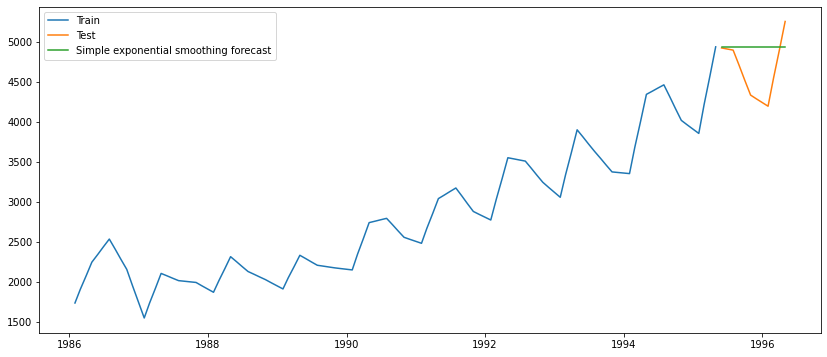

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.show()

**Holt method**

In [ ]:
hw_model  = Holt(Train["Sales"]).fit(optimized=True)
test_pred_hw = hw_model.forecast(12)
train_pred_hw = hw_model.fittedvalues
test_rmse_hw = np.sqrt(mean_squared_error(test_pred_hw,Test.Sales))
train_rmse_hw = np.sqrt(mean_squared_error(train_pred_hw,Train.Sales))
mape_hw = MAPE(test_rmse_hw,Test.Sales)
print('Holt Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hw),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hw))


Holt Method Evaluation 
 Mean Absolute Percent Error   = 36.234730703739466 
 Train Root Mean Squared Error = 114.05740483887503 
 Test Root Mean Squared Error  = 2945.824231328687


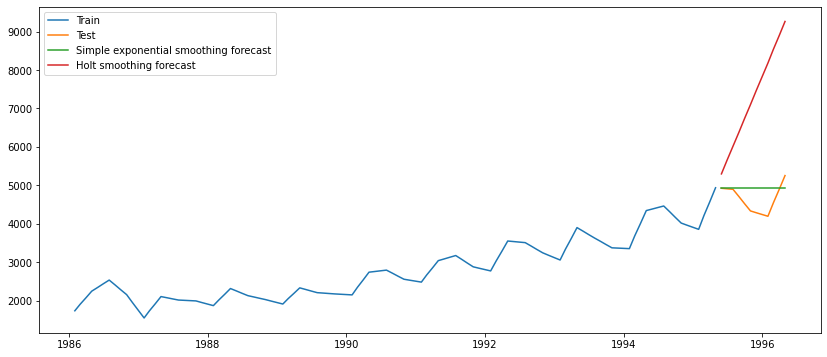

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.legend(loc='best')
plt.show()

**Holts winter exponential smoothing with additive seasonality and additive trend**

In [ ]:
holts_add_model  = ExponentialSmoothing(Train.Sales,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hltadd = holts_add_model.forecast(12)
train_pred_hltadd= holts_add_model.fittedvalues
test_rmse_hltadd = np.sqrt(mean_squared_error(test_pred_hltadd,Test.Sales))
train_rmse_hltadd = np.sqrt(mean_squared_error(train_pred_hltadd,Train.Sales))
mape_hltadd = MAPE(test_pred_hltadd,Test.Sales)
print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltadd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltadd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltadd))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 22.61175094756486 
 Train Root Mean Squared Error = 64.9411004791576 
 Test Root Mean Squared Error  = 1097.0212281970528


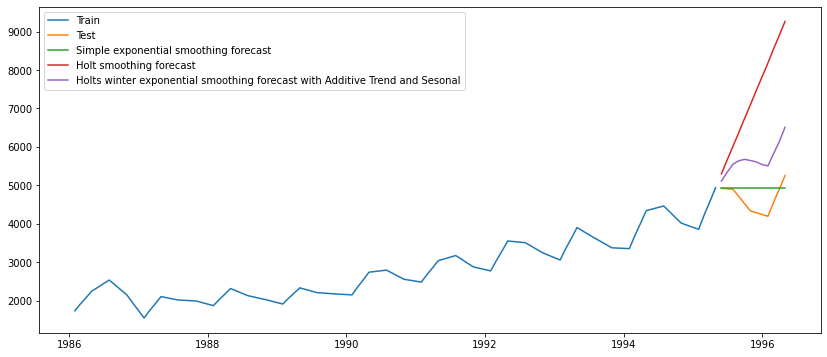

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

**Holts winter exponential smoothing with add seasonality and multipicative trend**

In [ ]:
holts_addmul_model  = ExponentialSmoothing(Train.Sales,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltaddmul = holts_addmul_model.forecast(12)
train_pred_hltaddmul= holts_addmul_model.fittedvalues
test_rmse_hltaddmul = np.sqrt(mean_squared_error(test_pred_hltaddmul,Test.Sales))
train_rmse_hltaddmul = np.sqrt(mean_squared_error(train_pred_hltaddmul,Train.Sales))
mape_hltaddmul = MAPE(test_pred_hltaddmul,Test.Sales)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltaddmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltaddmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltaddmul))

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 1.143270671999718 
 Train Root Mean Squared Error = 199.5842765476144 
 Test Root Mean Squared Error  = 59.63567592225503


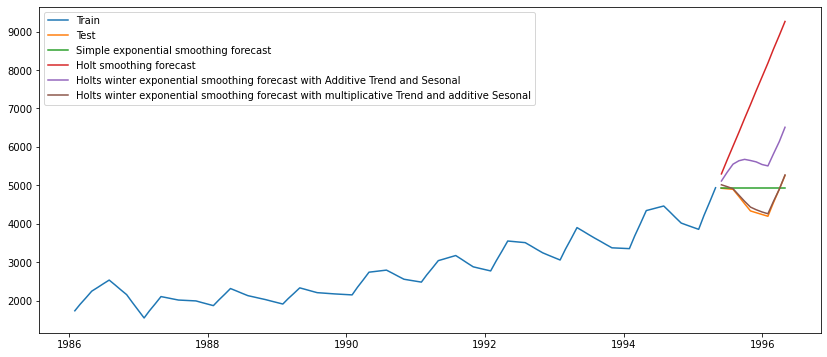

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.legend(loc='best')
plt.show()

**Holts winter exponential smoothing with multiplicative seasonality and multipicative trend**

In [ ]:
holts_muladd_model  = ExponentialSmoothing(Train.Sales,seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltmuladd = holts_muladd_model.forecast(12)
train_pred_hltmuladd= holts_muladd_model.fittedvalues
test_rmse_hltmuladd = np.sqrt(mean_squared_error(test_pred_hltmuladd,Test.Sales))
train_rmse_hltmuladd = np.sqrt(mean_squared_error(train_pred_hltmuladd,Train.Sales))
mape_hltmuladd = MAPE(test_pred_hltmuladd,Test.Sales)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmuladd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmuladd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmuladd))

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 2.223906327072386 
 Train Root Mean Squared Error = 166.4412652757838 
 Test Root Mean Squared Error  = 110.42737039258071


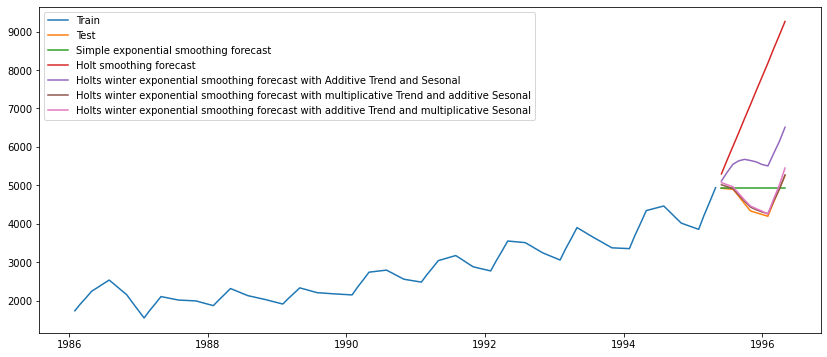

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

**Holts winter exponential smoothing with multiplicative seasonality and multipicative trend**

In [ ]:
holts_mul_model  = ExponentialSmoothing(Train.Sales,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_hltmul = holts_mul_model.forecast(12)
train_pred_hltmul= holts_mul_model.fittedvalues
test_rmse_hltmul = np.sqrt(mean_squared_error(test_pred_hltmul,Test.Sales))
train_rmse_hltmul = np.sqrt(mean_squared_error(train_pred_hltmul,Train.Sales))
mape_hltmul = MAPE(test_pred_hltmul,Test.Sales)
print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmul))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 3.5936726789398192 
 Train Root Mean Squared Error = 57.060185158435765 
 Test Root Mean Squared Error  = 207.4441988366664


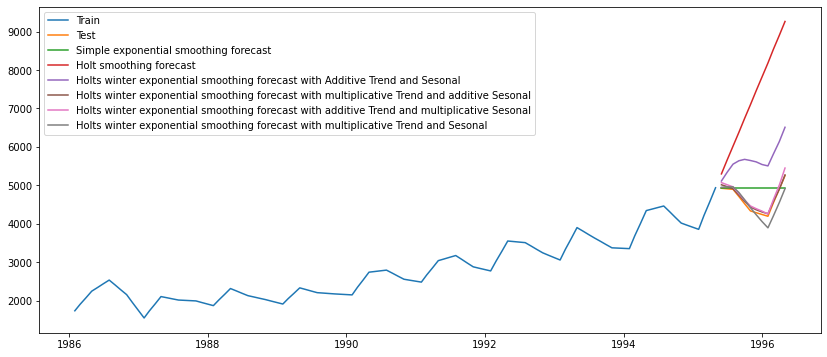

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.Sales, label='Train')
plt.plot(Test.Sales, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.plot(test_pred_hltmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and Sesonal')
plt.legend(loc='best')
plt.show()

### All Models results df

In [ ]:
all_mw = {"Models":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul"]),
        "Test_MAPE(%)":pd.Series(np.round([mape_ses,mape_hw,mape_hltadd,mape_hltaddmul,mape_hltmuladd,mape_hltmul],2)),
        "Train_RMSE":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul],2)),
        "Test_RMSE_Values":pd.Series(np.round([test_rmse_ses,test_rmse_hw,test_rmse_hltadd,test_rmse_hltaddmul,test_rmse_hltmuladd,test_rmse_hltmul],2))}
table_allmw=pd.DataFrame(all_mw)
table_allmw.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_allmw

,Models,Test_MAPE(%),Train_RMSE,Test_RMSE_Values
0,Holts_exp_addmul,1.14,199.58,59.64
1,Holts_exp_muladd,2.22,199.58,110.43
2,Holts_Exp_Mul,3.59,57.06,207.44
3,Simple_Exp,7.82,138.78,436.62
4,Holts_Exp_Add,22.61,64.94,1097.02
5,holts_exp,36.23,114.06,2945.82


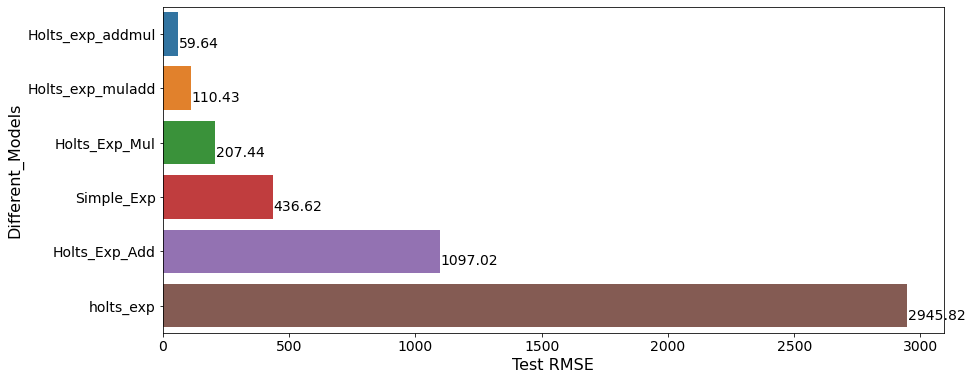

In [ ]:
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_allmw, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(table_allmw.Test_RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

###Final Model by combining train and test

In [ ]:
hwe_model_add_add = ExponentialSmoothing(cocacola_upsp.Sales,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)

In [ ]:
#Forecasting for next 12 time periods
hwe_model_add_add.forecast(12)

1996-05-31    5121.484381
1996-06-30    5099.875198
1996-07-31    5073.755820
1996-08-31    4905.854414
1996-09-30    4741.846307
                 ...     
1996-12-31    4496.772058
1997-01-31    4459.996015
1997-02-28    4804.255060
1997-03-31    5144.583913
1997-04-30    5421.794696
Freq: M, Length: 12, dtype: float64

##Forecasting_Model_based_methods

In [ ]:
cocacola_upsp

,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
Date,,,,,,,,,,,,,,,,,,
1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223


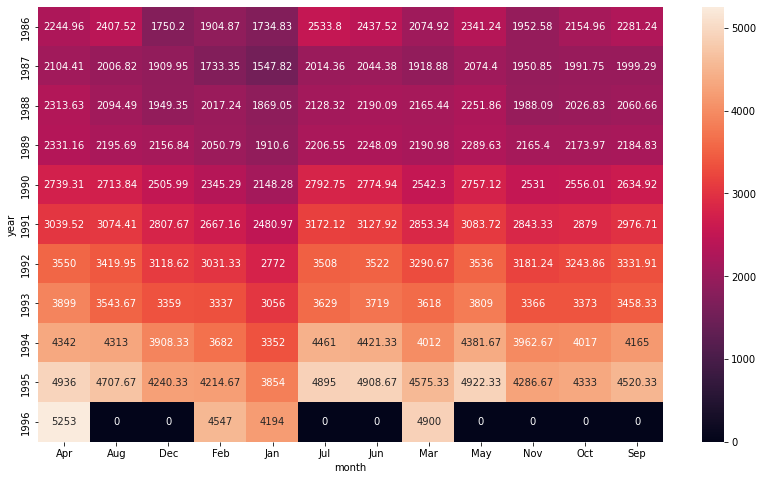

In [ ]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=cocacola_upsp,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

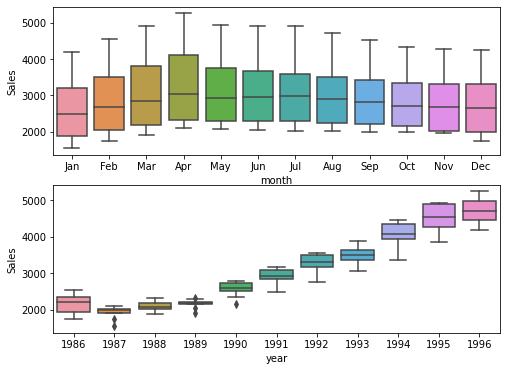

In [ ]:
# box plot for ever
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x='month',y='Sales',data=cocacola_upsp)
plt.subplot(212)
sns.boxplot(x='year',y='Sales',data=cocacola_upsp)

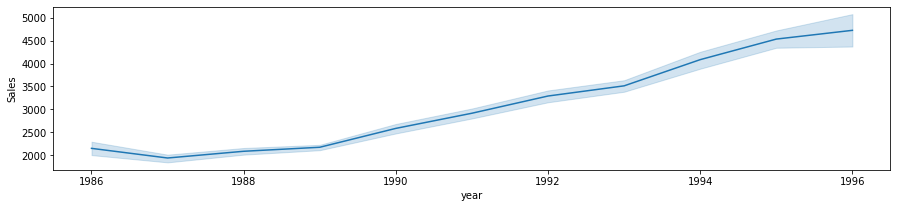

In [ ]:
plt.figure(figsize=(15,3))
sns.lineplot(x='year',y='Sales',data=cocacola_upsp)

In [ ]:
Train=cocacola_upsp.head(112)
Test=cocacola_upsp.tail(12)
Test

,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
Date,,,,,,,,,,,,,,,,,,
1995-05-31,4922.333333,113,12769,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,8.501538
1995-06-30,4908.666667,114,12996,Jun,1995,0,0,0,0,0,1,0,0,0,0,0,0,8.498758
1995-07-31,4895.000000,115,13225,Jul,1995,0,0,0,0,0,0,1,0,0,0,0,0,8.495970
1995-08-31,4707.666667,116,13456,Aug,1995,0,0,0,0,0,0,0,1,0,0,0,0,8.456948
1995-09-30,4520.333333,117,13689,Sep,1995,0,0,0,0,0,0,0,0,1,0,0,0,8.416341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223


**i)Linear model**

In [ ]:

import statsmodels.formula.api as smf
linear_model=smf.ols('Sales~t',data=Train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rsme_linear=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rsme_linear

561.9428078334439

**ii)Exponential Model**

In [ ]:
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

432.87831178706824

**iii)Quadratic Model**

In [ ]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

416.124047362576

**iv)Additive seasonality**

In [ ]:
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1840.3042900245862

**v)Additive Seasonality Quadratic**

In [ ]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

271.9062333127489

**vi)Multiplicative Seasonality**

In [ ]:
Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1939.082378199316

**vii)Multiplicative Additive Seasonality**

In [ ]:
Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

236.26364020378006

###Compare the results 

In [ ]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series(np.round([rsme_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea],2))}
table_rmse=pd.DataFrame(data)
table_rmse=table_rmse.sort_values(['RMSE_Values'])
table_rmse

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,236.26
4,rmse_add_sea_quad,271.91
2,rmse_Quad,416.12
1,rmse_Exp,432.88
0,rmse_linear,561.94
3,rmse_add_sea,1840.30
5,rmse_Mult_sea,1939.08


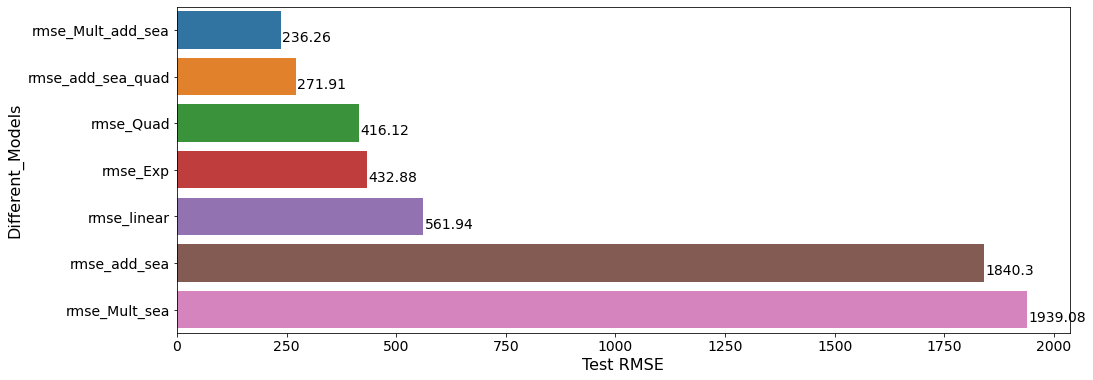

In [ ]:
f, axe = plt.subplots(1,1, figsize=(16,6))
sns.barplot(x='RMSE_Values', y='MODEL', data=table_rmse, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(table_rmse.RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

## ARIMA Hyperparameters

In [ ]:
# walk-forward validation
history = [x for x in Train.Sales]
predictions = []
for i in range(len(Test.Sales)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = Test.Sales[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = np.sqrt(mean_squared_error(Test.Sales, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=4936.000, Expected=4922.333
>Predicted=4922.333, Expected=4908.667
>Predicted=4908.667, Expected=4895.000
>Predicted=4895.000, Expected=4707.667
>Predicted=4707.667, Expected=4520.333
>Predicted=4520.333, Expected=4333.000
>Predicted=4333.000, Expected=4286.667
>Predicted=4286.667, Expected=4240.333
>Predicted=4240.333, Expected=4194.000
>Predicted=4194.000, Expected=4547.000
>Predicted=4547.000, Expected=4900.000
>Predicted=4900.000, Expected=5253.000
RMSE: 201.269


In [ ]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                  rmse = evaluate_arima_model(Train.Sales, order)
                  if rmse < best_score:
                      best_score, best_cfg = rmse, order
                      print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(Train.Sales, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1089.532
ARIMA(0, 0, 1) RMSE=599.885
ARIMA(0, 1, 0) RMSE=158.930
ARIMA(0, 1, 1) RMSE=129.612
ARIMA(0, 2, 3) RMSE=93.044
ARIMA(1, 1, 2) RMSE=92.217
ARIMA(2, 1, 2) RMSE=92.203
ARIMA(4, 1, 3) RMSE=88.794
Best ARIMA(4, 1, 3) RMSE=88.794


### Build Model based on the optimized values

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  111
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -638.282
Method:                       css-mle   S.D. of innovations             72.974
Date:                Mon, 20 Feb 2023   AIC                           1294.563
Time:                        14:10:31   BIC                           1318.949
Sample:                    02-28-1986   HQIC                          1304.456
                         - 04-30-1995                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.4898      5.768      3.899      0.000      11.185      33.795
ar.L1.D.Sales     0.6547      0.120      5.437      0.000       0.419       0.891
ar.L2.D.Sales     0.1175      0.129     

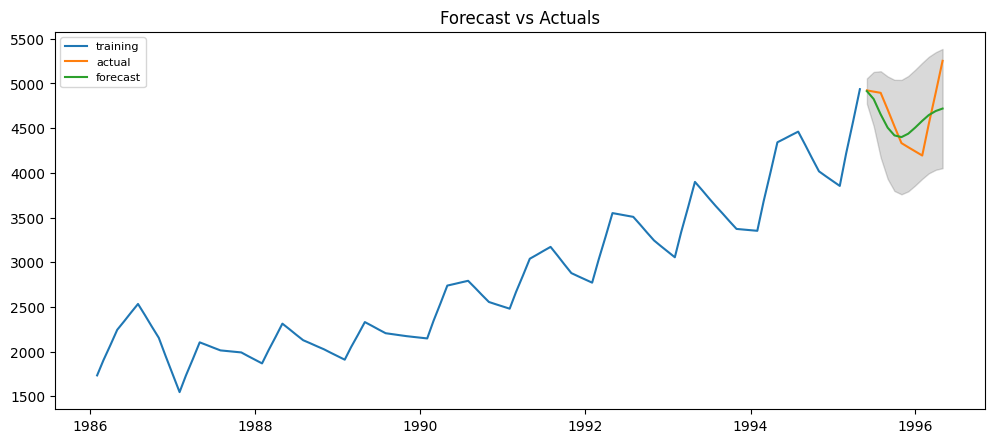

In [ ]:
# Build Model
model = ARIMA(Train.Sales, order=(4, 1, 3))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Test.index)
lower_series = pd.Series(conf[:, 0], index=Test.index)
upper_series = pd.Series(conf[:, 1], index=Test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Train.Sales, label='training')
plt.plot(Test.Sales, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
Arima_rmse = np.mean((fc - Test.Sales)**2)**.5
Arima_rmse

242.07890180202256

#Conclusion:

In [ ]:
pd.reset_option('display.max_rows')
all_rsme={"MODEL":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul","rmse_linear",
                             "rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea","ARIMA"]),
        "RMSE_Values":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul,
                                          rsme_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea,Arima_rmse],2))}
tab_rmse=pd.DataFrame(all_rsme)
tab_rmse=tab_rmse.sort_values(['RMSE_Values'])
tab_rmse

,MODEL,RMSE_Values
5,Holts_Exp_Mul,57.06
2,Holts_Exp_Add,64.94
1,holts_exp,114.06
0,Simple_Exp,138.78
3,Holts_exp_addmul,199.58
4,Holts_exp_muladd,199.58
12,rmse_Mult_add_sea,236.26
13,ARIMA,242.08
10,rmse_add_sea_quad,271.91
8,rmse_Quad,416.12


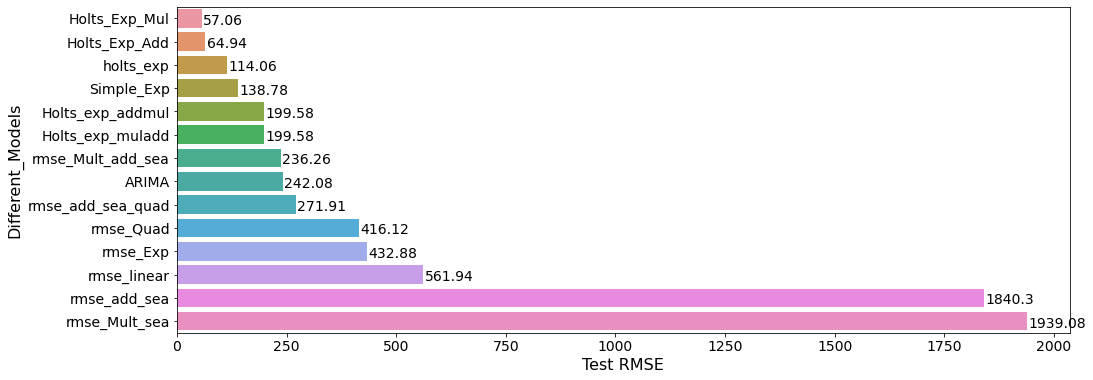

In [ ]:
f, axe = plt.subplots(1,1, figsize=(16,6))
sns.barplot(x='RMSE_Values', y='MODEL', data=tab_rmse, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(tab_rmse.RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

*  Holts_exp_mul and Holts_exp_add are giving least RMSE out of all the models, and these will be useful for forecasting.



---



#Problem-2)

**Forecast the Airlines Passengers data set. Prepare a document for each model explaining** 

**How many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.**


#Solution:

In [ ]:
#Data loading
from google.colab import files
uploaded=files.upload()

Saving Airlines+Data.xlsx to Airlines+Data.xlsx


In [ ]:
airlines=pd.read_excel('Airlines+Data.xlsx')
airlines

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


##Basic & EDA

In [ ]:
airlines.shape

(96, 2)

In [ ]:
airlines.rename(columns = {'Month':'date','Passengers':'passengers'}, inplace = True)

In [ ]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        96 non-null     datetime64[ns]
 1   passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


* Datatypes of all features are correct.

In [ ]:
airlines.nunique()

date          96
passengers    80
dtype: int64

In [ ]:
airlines.isna().sum()

date          0
passengers    0
dtype: int64

*  There are no null values in the given dataset. 

In [ ]:
airlines.duplicated().value_counts()

False    96
dtype: int64

*  There are no duplicate records in the given dataset. 

In [ ]:
airlines.describe().T

,count,mean,std,min,25%,50%,75%,max
passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


In [ ]:
airlines.set_index('date',inplace=True)
airlines

,passengers
date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [ ]:
upsampled_month = airlines['passengers']
upsampled_month = upsampled_month.resample('M').mean()
pd.set_option('display.max_rows', 10)
upsampled_month

date
1995-01-31    112.0
1995-02-28    118.0
1995-03-31    132.0
1995-04-30    129.0
1995-05-31    121.0
              ...  
2002-08-31    405.0
2002-09-30    355.0
2002-10-31    306.0
2002-11-30    271.0
2002-12-31    306.0
Freq: M, Name: passengers, Length: 96, dtype: float64

In [ ]:
interpolated_month = upsampled_month.interpolate(method='linear')
interpolated_month=pd.DataFrame(interpolated_month)
interpolated_month

,passengers
date,
1995-01-31,112.0
1995-02-28,118.0
1995-03-31,132.0
1995-04-30,129.0
1995-05-31,121.0
...,...
2002-08-31,405.0
2002-09-30,355.0
2002-10-31,306.0


In [ ]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.date.dt.strftime("%b") # month 
interpolated_month["year"] =pd.to_numeric( interpolated_month.date.dt.strftime("%Y")) # year
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
airlines_upsp = pd.concat([interpolated_month,months],axis=1)
airlines_upsp['log_passengers'] = np.log(airlines_upsp['passengers'])
airlines_upsp


,date,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
92,2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
93,2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585
94,2002-11-30,271.0,95,9025,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0,5.602119


In [ ]:
airlines_upsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            96 non-null     datetime64[ns]
 1   passengers      96 non-null     float64       
 2   t               96 non-null     int64         
 3   t_squared       96 non-null     int64         
 4   month           96 non-null     object        
 5   year            96 non-null     int64         
 6   Jan             96 non-null     uint8         
 7   Feb             96 non-null     uint8         
 8   Mar             96 non-null     uint8         
 9   Apr             96 non-null     uint8         
 10  May             96 non-null     uint8         
 11  Jun             96 non-null     uint8         
 12  Jul             96 non-null     uint8         
 13  Aug             96 non-null     uint8         
 14  Sep             96 non-null     uint8         
 15  Oct     

##Visualizing Data Points

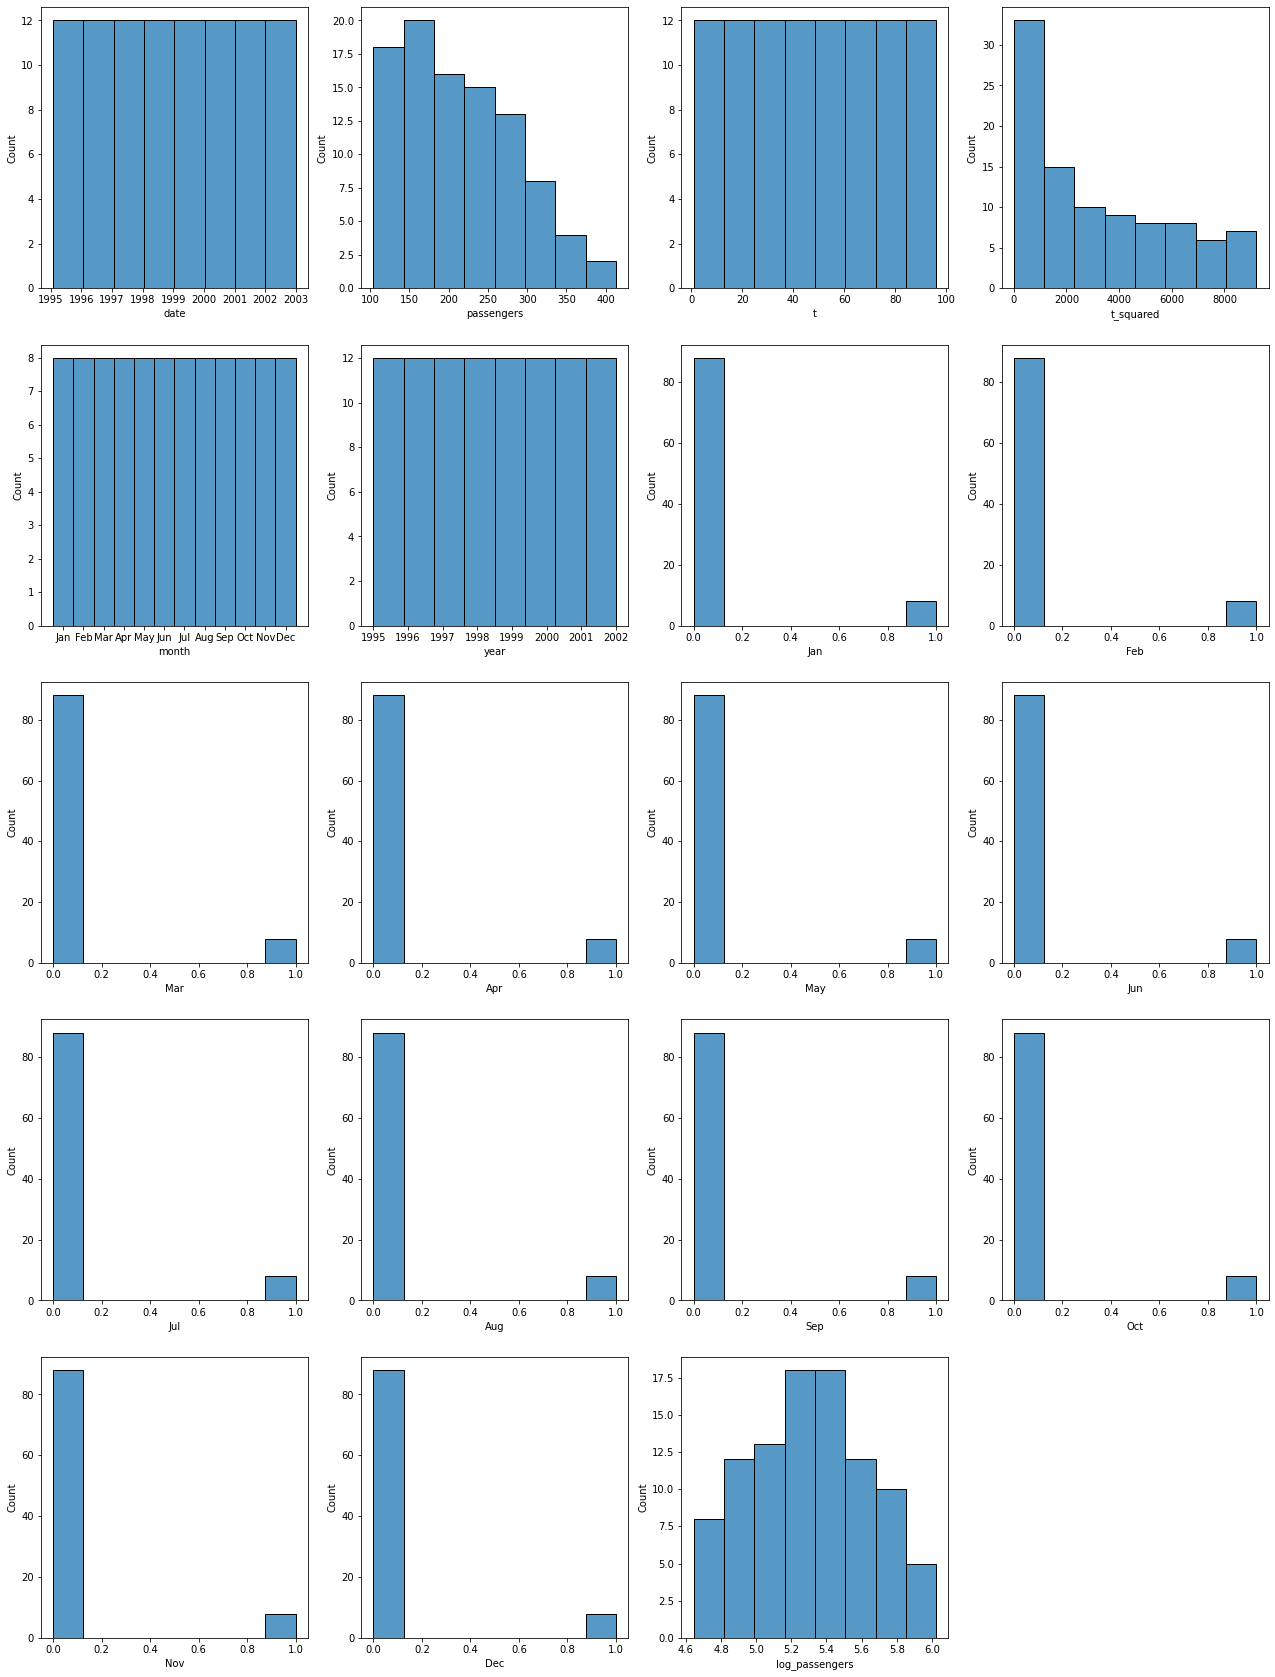

In [ ]:
#plotting histplots to observe datapoints nature
plt.figure(figsize=(22,30))
for i, column in enumerate(airlines_upsp.columns, 1):
    plt.subplot(5,4,i)
    sns.histplot(airlines_upsp[column])

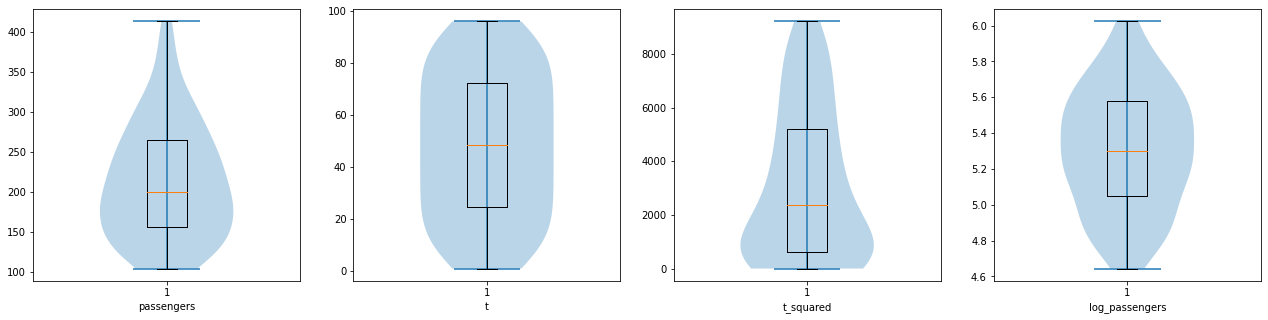

In [ ]:
#plotting boxplots to observe datapoints nature
plt.figure(figsize=(22,5))
for i, column in enumerate(['passengers','t','t_squared','log_passengers'], 1):
    plt.subplot(1,4,i)
    plt.violinplot(airlines_upsp[column])
    plt.boxplot(airlines_upsp[column])
    plt.xlabel(airlines_upsp[column].name)

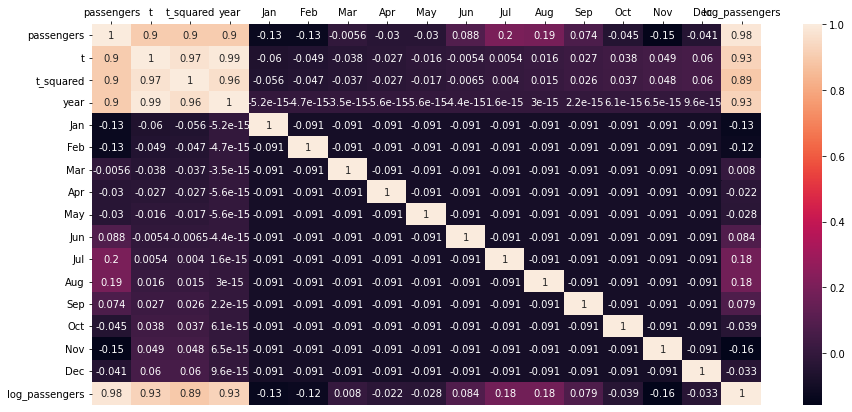

In [ ]:
#plotting the heatmap for correlation
plt.figure(figsize=(15,7))
ax = sns.heatmap(airlines_upsp.corr(), annot=True)
ax.xaxis.tick_top()

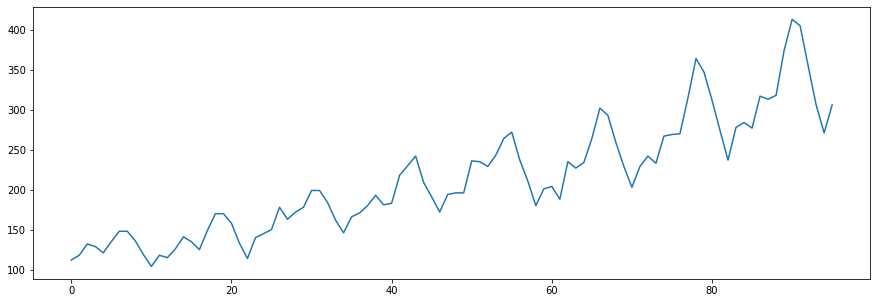

In [ ]:
airlines_upsp['passengers'].plot(figsize=(15, 5))
plt.show()

**Moving Average** 

In [ ]:
airlines_upsp.set_index('date',inplace=True)
airlines_upsp.head()

,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
date,,,,,,,,,,,,,,,,,,
1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791


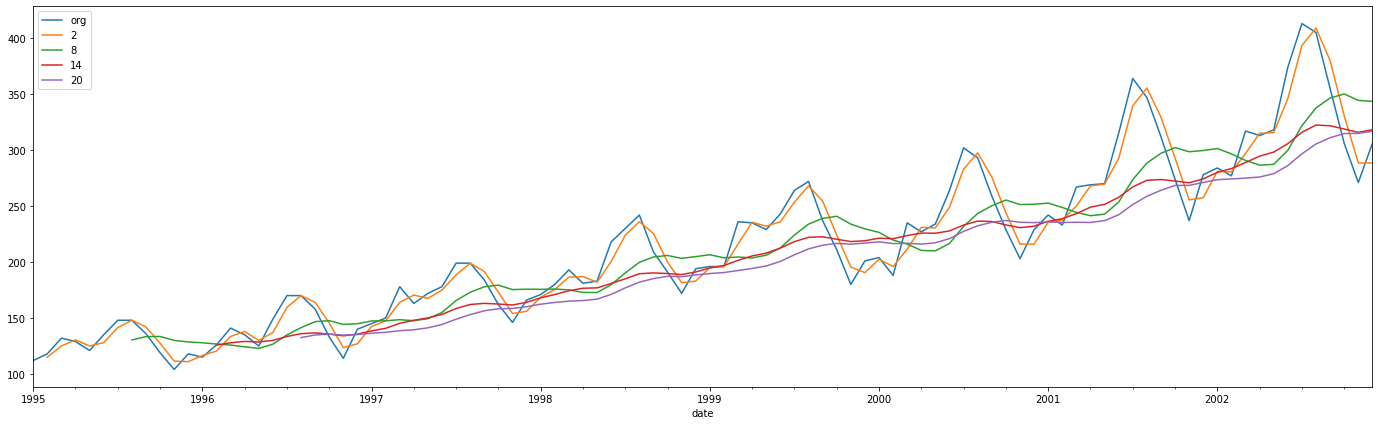

In [ ]:
plt.figure(figsize=(24,7))
airlines_upsp.passengers.plot(label="org")
for i in range(2,24,6):
    airlines_upsp['passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

**Time series decomposition plot**


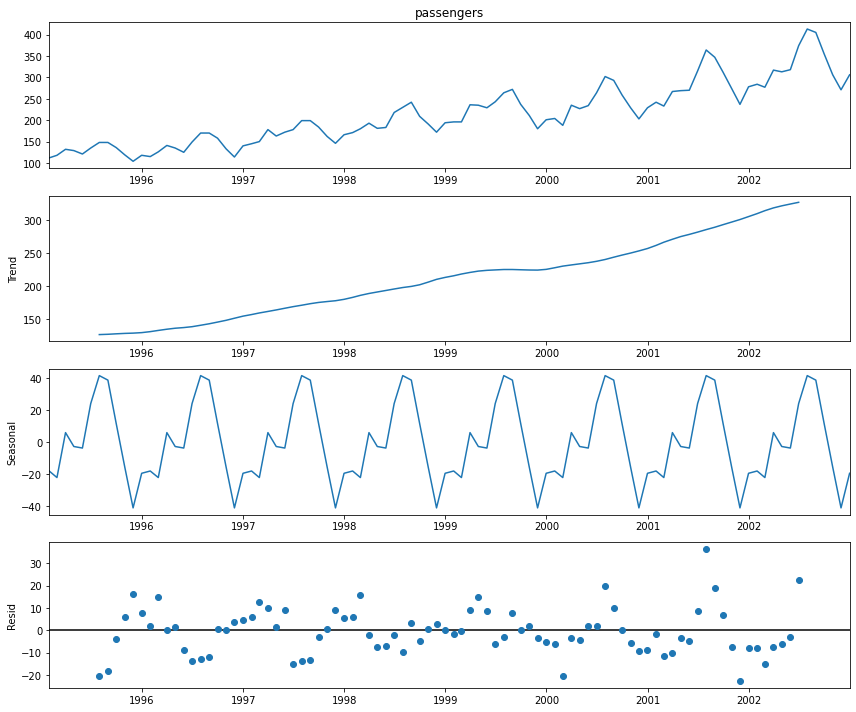

In [ ]:
decompose_ts_add = seasonal_decompose(airlines_upsp.passengers,freq= 12)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

**ACF plots and PACF plots**

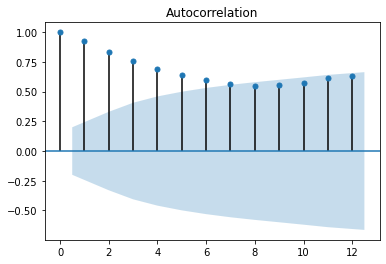

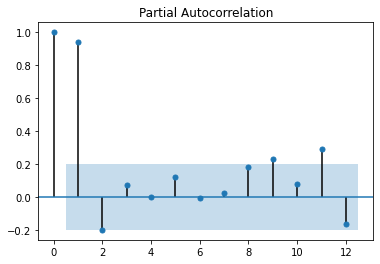

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airlines_upsp.passengers,lags=12)
tsa_plots.plot_pacf(airlines_upsp.passengers,lags=12)
plt.show()

##Splitting data

In [ ]:
airlines_upsp.shape

(96, 18)

In [ ]:
Train=airlines_upsp.head(84)
Test=airlines_upsp.tail(12)

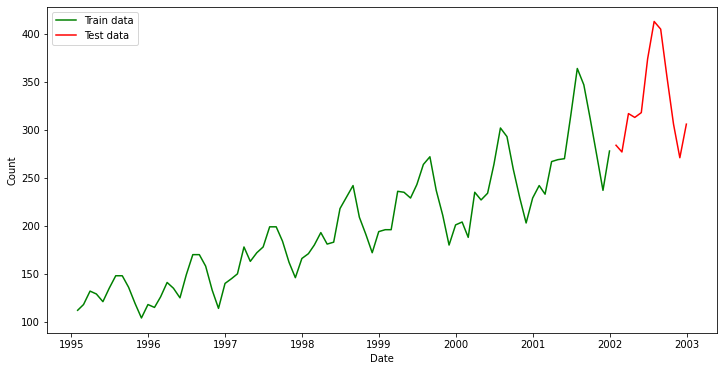

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(Train.passengers, 'green', label='Train data')
plt.plot(Test.passengers, 'red', label='Test data')
plt.legend()
plt.show()

##Forecasting_Data_Driven_Models

**Evaluation Metric MAPE**

In [ ]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

**Simple Exponential Method**

In [ ]:
from sklearn.metrics import mean_squared_error
ses_model = SimpleExpSmoothing(Train['passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(12)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,Test.passengers))
train_rmse_ses = np.sqrt(mean_squared_error(train_pred_ses,Train.passengers))
mape_ses = MAPE(test_pred_ses,Test.passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 14.235433154627977 
 Train Root Mean Squared Error = 21.247969155479584 
 Test Root Mean Squared Error  = 68.00674031349585


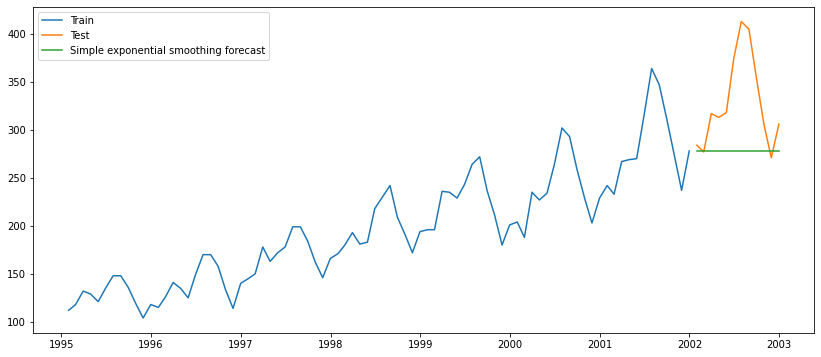

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.show()

**Holt method**

In [ ]:
hw_model  = Holt(Train["passengers"]).fit(optimized=True)
test_pred_hw = hw_model.forecast(12)
train_pred_hw = hw_model.fittedvalues
test_rmse_hw = np.sqrt(mean_squared_error(test_pred_hw,Test.passengers))
train_rmse_hw = np.sqrt(mean_squared_error(train_pred_hw,Train.passengers))
mape_hw = MAPE(test_rmse_hw,Test.passengers)
print('Holt Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hw),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hw))


Holt Method Evaluation 
 Mean Absolute Percent Error   = 81.82504047003955 
 Train Root Mean Squared Error = 21.154758639240143 
 Test Root Mean Squared Error  = 58.57776020000329


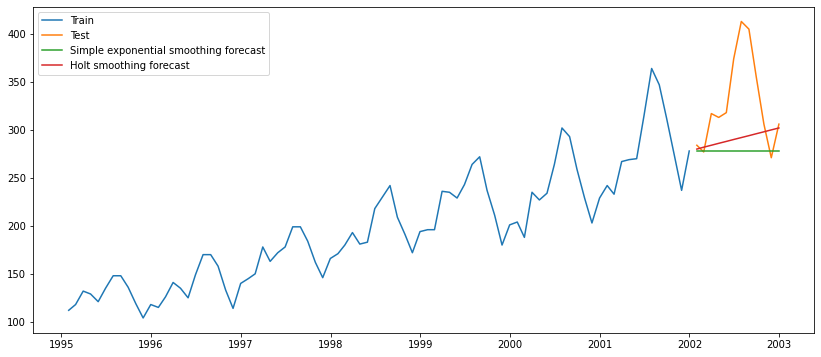

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.legend(loc='best')
plt.show()

**Holts winter exponential smoothing with additive seasonality and additive trend**

In [ ]:
holts_add_model  = ExponentialSmoothing(Train.passengers,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hltadd = holts_add_model.forecast(12)
train_pred_hltadd= holts_add_model.fittedvalues
test_rmse_hltadd = np.sqrt(mean_squared_error(test_pred_hltadd,Test.passengers))
train_rmse_hltadd = np.sqrt(mean_squared_error(train_pred_hltadd,Train.passengers))
mape_hltadd = MAPE(test_pred_hltadd,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltadd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltadd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltadd))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 5.499858437809377 
 Train Root Mean Squared Error = 9.225245812973158 
 Test Root Mean Squared Error  = 28.8095571658956


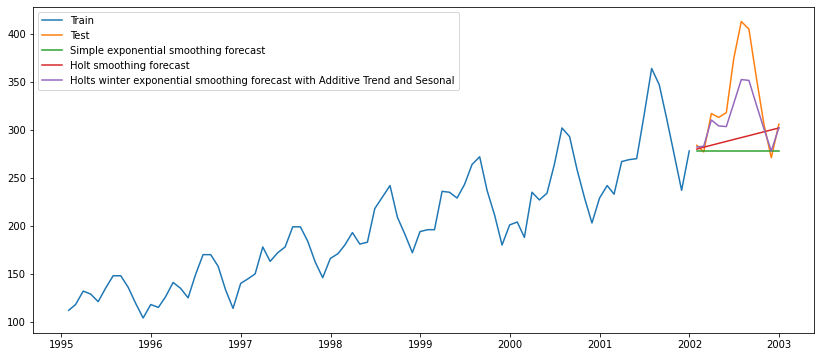

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

**Holts winter exponential smoothing with add seasonality and multipicative trend**

In [ ]:
holts_addmul_model  = ExponentialSmoothing(Train.passengers,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltaddmul = holts_addmul_model.forecast(12)
train_pred_hltaddmul= holts_addmul_model.fittedvalues
test_rmse_hltaddmul = np.sqrt(mean_squared_error(test_pred_hltaddmul,Test.passengers))
train_rmse_hltaddmul = np.sqrt(mean_squared_error(train_pred_hltaddmul,Train.passengers))
mape_hltaddmul = MAPE(test_pred_hltaddmul,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltaddmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltaddmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltaddmul))

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 2.3243813714974837 
 Train Root Mean Squared Error = 12.720942843437003 
 Test Root Mean Squared Error  = 11.221826856956627


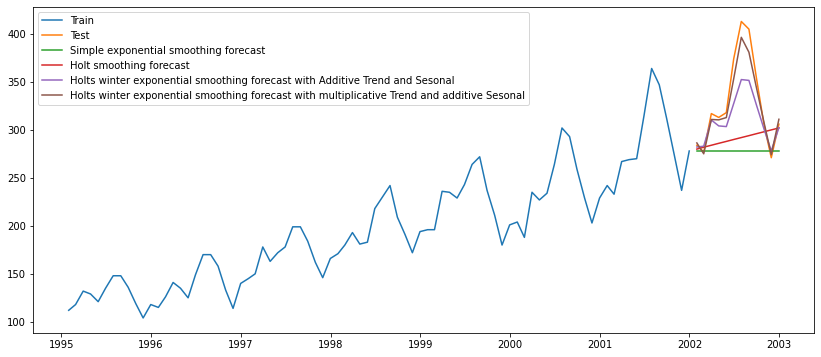

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.legend(loc='best')
plt.show()

**Holts winter exponential smoothing with multiplicative seasonality and multipicative trend**

In [ ]:
holts_muladd_model  = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_hltmuladd = holts_muladd_model.forecast(12)
train_pred_hltmuladd= holts_muladd_model.fittedvalues
test_rmse_hltmuladd = np.sqrt(mean_squared_error(test_pred_hltmuladd,Test.passengers))
train_rmse_hltmuladd = np.sqrt(mean_squared_error(train_pred_hltmuladd,Train.passengers))
mape_hltmuladd = MAPE(test_pred_hltmuladd,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmuladd),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmuladd),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmuladd))

Holts winter exponential smoothing  with Additive Trend and multiplicative Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 6.814492368935664 
 Train Root Mean Squared Error = 9.81792931243543 
 Test Root Mean Squared Error  = 23.371163615412907


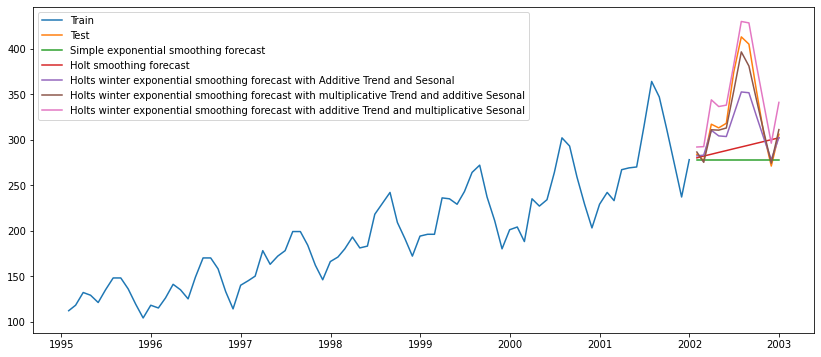

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

**Holts winter exponential smoothing with multiplicative seasonality and multipicative trend**

In [ ]:
holts_mul_model  = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_hltmul = holts_mul_model.forecast(12)
train_pred_hltmul= holts_mul_model.fittedvalues
test_rmse_hltmul = np.sqrt(mean_squared_error(test_pred_hltmul,Test.passengers))
train_rmse_hltmul = np.sqrt(mean_squared_error(train_pred_hltmul,Train.passengers))
mape_hltmul = MAPE(test_pred_hltmul,Test.passengers)
print('Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_hltmul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hltmul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_hltmul))

Holts winter exponential smoothing  with Additive Trend and Seasonality Method Evaluation 
 Mean Absolute Percent Error   = 1.9395385155449334 
 Train Root Mean Squared Error = 6.802696521706271 
 Test Root Mean Squared Error  = 7.756902067074813


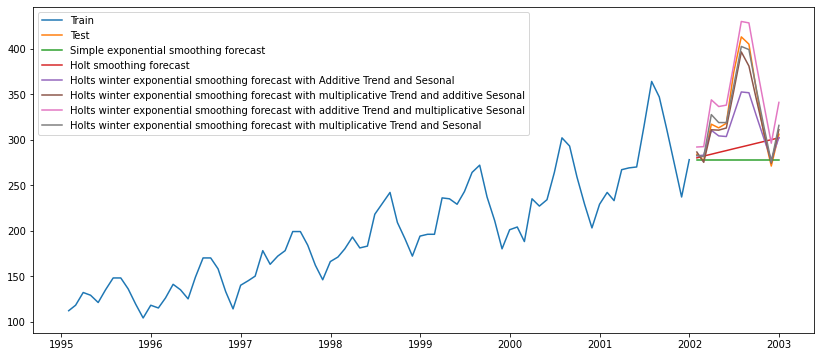

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(Train.passengers, label='Train')
plt.plot(Test.passengers, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hw, label='Holt smoothing forecast')
plt.plot(test_pred_hltadd, label='Holts winter exponential smoothing forecast with Additive Trend and Sesonal')
plt.plot(test_pred_hltaddmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and additive Sesonal')
plt.plot(test_pred_hltmuladd, label='Holts winter exponential smoothing forecast with additive Trend and multiplicative Sesonal')
plt.plot(test_pred_hltmul, label='Holts winter exponential smoothing forecast with multiplicative Trend and Sesonal')
plt.legend(loc='best')
plt.show()

### All Models results df

In [ ]:
all_mw = {"Models":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul"]),
        "Test_MAPE(%)":pd.Series(np.round([mape_ses,mape_hw,mape_hltadd,mape_hltaddmul,mape_hltmuladd,mape_hltmul],2)),
        "Train_RMSE":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul],2)),
        "Test_RMSE_Values":pd.Series(np.round([test_rmse_ses,test_rmse_hw,test_rmse_hltadd,test_rmse_hltaddmul,test_rmse_hltmuladd,test_rmse_hltmul],2))}
table_allmw=pd.DataFrame(all_mw)
table_allmw.sort_values(['Test_RMSE_Values'], inplace=True, ignore_index=True)
table_allmw

,Models,Test_MAPE(%),Train_RMSE,Test_RMSE_Values
0,Holts_Exp_Mul,1.94,6.80,7.76
1,Holts_exp_addmul,2.32,12.72,11.22
2,Holts_exp_muladd,6.81,12.72,23.37
3,Holts_Exp_Add,5.50,9.23,28.81
4,holts_exp,81.83,21.15,58.58
5,Simple_Exp,14.24,21.25,68.01


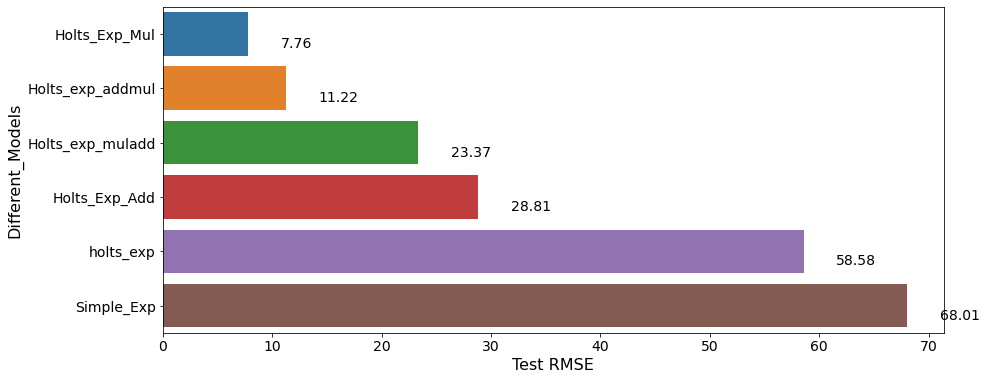

In [ ]:
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_allmw, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(table_allmw.Test_RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

###Final Model by combining train and test

In [ ]:
hwe_model_mul = ExponentialSmoothing(Train.passengers,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)

In [ ]:
#Forecasting for next 12 time periods
hwe_model_mul.forecast(12)

2002-01-31    282.796650
2002-02-28    281.344324
2002-03-31    327.552542
2002-04-30    318.796862
2002-05-31    318.782301
                 ...    
2002-08-31    399.066131
2002-09-30    355.992724
2002-10-31    314.505525
2002-11-30    275.383197
2002-12-31    315.686190
Freq: M, Length: 12, dtype: float64

##Forecasting_Model_based_methods

In [ ]:
airlines_upsp

,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
date,,,,,,,,,,,,,,,,,,
1995-01-31,112.0,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1995-02-28,118.0,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
1995-03-31,132.0,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
1995-04-30,129.0,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
1995-05-31,121.0,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585


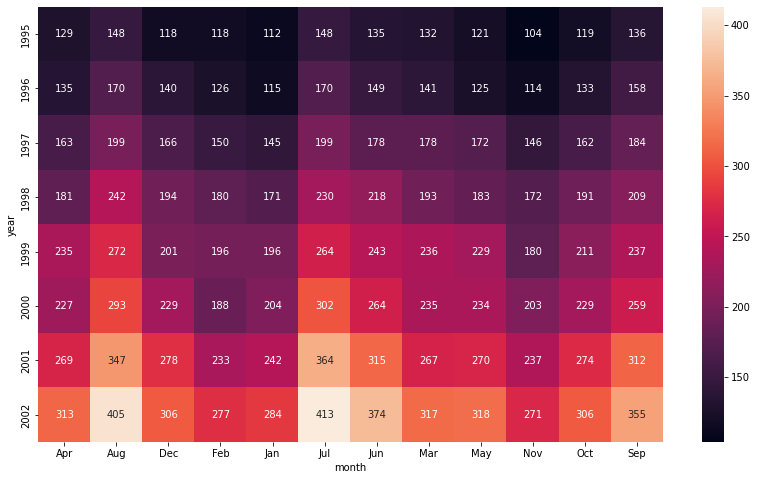

In [ ]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=airlines_upsp,values="passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

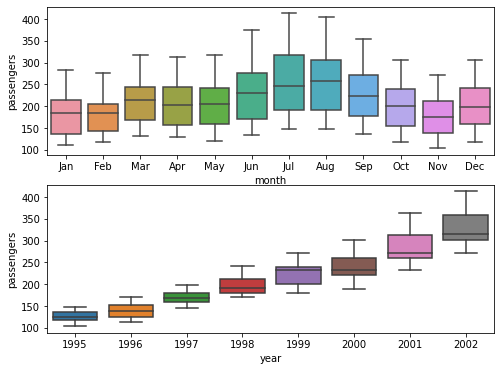

In [ ]:
# box plot for ever
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x='month',y='passengers',data=airlines_upsp)
plt.subplot(212)
sns.boxplot(x='year',y='passengers',data=airlines_upsp)

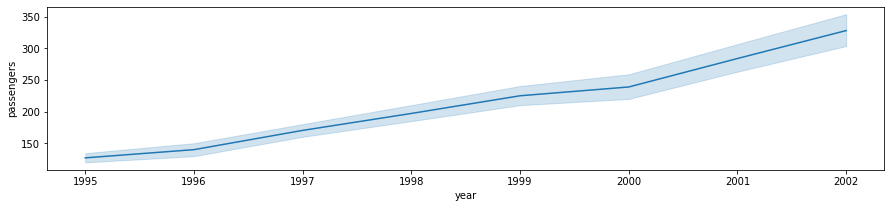

In [ ]:
plt.figure(figsize=(15,3))
sns.lineplot(x='year',y='passengers',data=airlines_upsp)

In [ ]:
Train=airlines_upsp.head(84)
Test=airlines_upsp.tail(12)
Test

,passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
date,,,,,,,,,,,,,,,,,,
2002-01-31,284.0,85,7225,Jan,2002,1,0,0,0,0,0,0,0,0,0,0,0,5.648974
2002-02-28,277.0,86,7396,Feb,2002,0,1,0,0,0,0,0,0,0,0,0,0,5.624018
2002-03-31,317.0,87,7569,Mar,2002,0,0,1,0,0,0,0,0,0,0,0,0,5.758902
2002-04-30,313.0,88,7744,Apr,2002,0,0,0,1,0,0,0,0,0,0,0,0,5.746203
2002-05-31,318.0,89,7921,May,2002,0,0,0,0,1,0,0,0,0,0,0,0,5.762051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-31,405.0,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
2002-09-30,355.0,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
2002-10-31,306.0,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585


**i)Linear model**

In [ ]:

import statsmodels.formula.api as smf
linear_model=smf.ols('passengers~t',data=Train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rsme_linear=np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_linear))**2))
rsme_linear

53.19923653480278

**ii)Exponential Model**

In [ ]:
Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.05736110315654

**iii)Quadratic Model**

In [ ]:
Quad = smf.ols('passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_Quad))**2))
rmse_Quad

48.05188897933164

**iv)Additive seasonality**

In [ ]:
add_sea = smf.ols('passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

132.81978481421817

**v)Additive Seasonality Quadratic**

In [ ]:
add_sea_Quad = smf.ols('passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

26.3608176120952

**vi)Multiplicative Seasonality**

In [ ]:
Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

140.06320204708632

**vii)Multiplicative Additive Seasonality**

In [ ]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

10.519172544323876

###Compare the results 

In [ ]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series(np.round([rsme_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea],2))}
table_rmse=pd.DataFrame(data)
table_rmse=table_rmse.sort_values(['RMSE_Values'])
table_rmse

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,10.52
4,rmse_add_sea_quad,26.36
1,rmse_Exp,46.06
2,rmse_Quad,48.05
0,rmse_linear,53.20
3,rmse_add_sea,132.82
5,rmse_Mult_sea,140.06


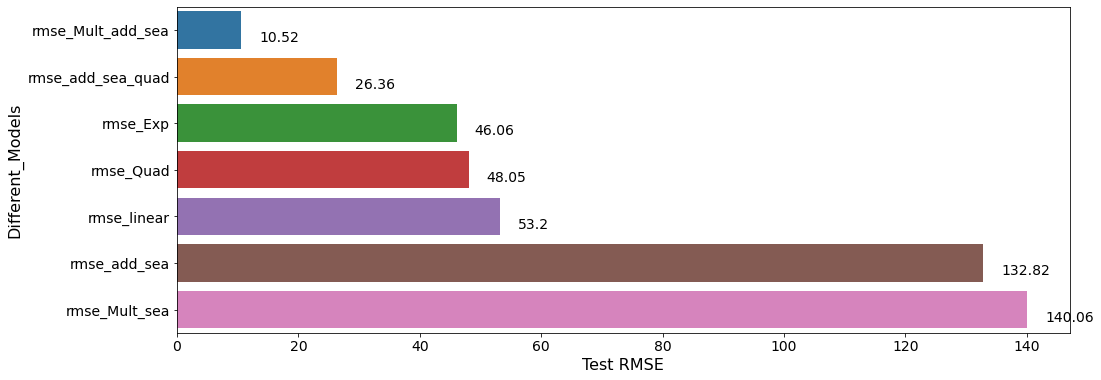

In [ ]:
f, axe = plt.subplots(1,1, figsize=(16,6))
sns.barplot(x='RMSE_Values', y='MODEL', data=table_rmse, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(table_rmse.RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

## ARIMA Hyperparameters

In [ ]:
Train=airlines_upsp.head(84)
Test=airlines_upsp.tail(12)

In [ ]:
# walk-forward validation
history = [x for x in Train.passengers]
predictions = []
for i in range(len(Test.passengers)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = Test.passengers[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = np.sqrt(mean_squared_error(Test.passengers, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=278.000, Expected=284.000
>Predicted=284.000, Expected=277.000
>Predicted=277.000, Expected=317.000
>Predicted=317.000, Expected=313.000
>Predicted=313.000, Expected=318.000
>Predicted=318.000, Expected=374.000
>Predicted=374.000, Expected=413.000
>Predicted=413.000, Expected=405.000
>Predicted=405.000, Expected=355.000
>Predicted=355.000, Expected=306.000
>Predicted=306.000, Expected=271.000
>Predicted=271.000, Expected=306.000
RMSE: 33.909


                             ARIMA Model Results                              
Dep. Variable:          D2.passengers   No. Observations:                   82
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -365.264
Method:                       css-mle   S.D. of innovations             20.217
Date:                Mon, 20 Feb 2023   AIC                            742.529
Time:                        13:54:59   BIC                            756.969
Sample:                    03-31-1995   HQIC                           748.326
                         - 12-31-2001                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0110      0.088      0.125      0.900      -0.162       0.184
ar.L1.D2.passengers     0.2496      0.112      2.223      0.026       0.029       0.470
ar.L2.D2.passeng

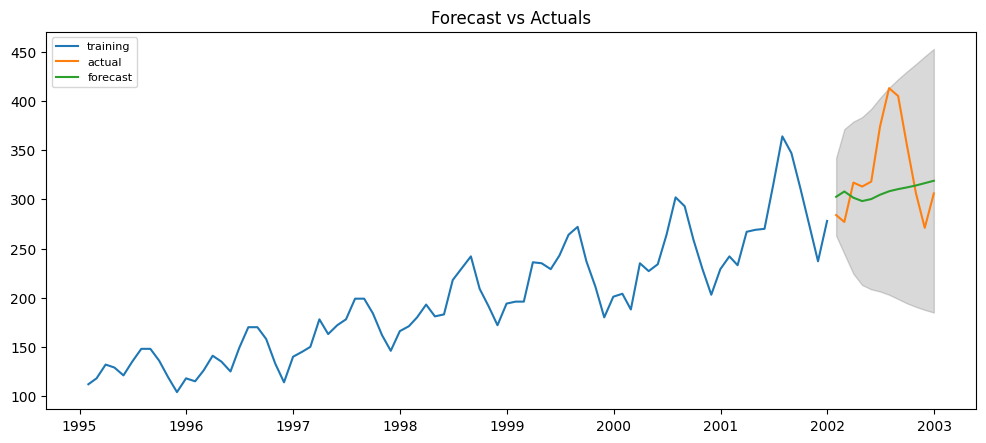

In [ ]:
# Build Model
model = ARIMA(Train.passengers, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Test.index)
lower_series = pd.Series(conf[:, 0], index=Test.index)
upper_series = pd.Series(conf[:, 1], index=Test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Train.passengers, label='training')
plt.plot(Test.passengers, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
Arima_rmse = np.mean((fc - Test.passengers)**2)**.5
Arima_rmse

50.791023949103575

#Conclusion:

In [ ]:
pd.reset_option('display.max_rows')
all_rsme={"MODEL":pd.Series(["Simple_Exp","holts_exp","Holts_Exp_Add","Holts_exp_addmul","Holts_exp_muladd","Holts_Exp_Mul","rmse_linear",
                             "rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea","ARIMA"]),
        "RMSE_Values":pd.Series(np.round([train_rmse_ses,train_rmse_hw,train_rmse_hltadd,train_rmse_hltaddmul,train_rmse_hltaddmul,train_rmse_hltmul,
                                          rsme_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea,Arima_rmse],2))}
tab_rmse=pd.DataFrame(all_rsme)
tab_rmse=tab_rmse.sort_values(['RMSE_Values'])
tab_rmse

,MODEL,RMSE_Values
5,Holts_Exp_Mul,6.80
2,Holts_Exp_Add,9.23
12,rmse_Mult_add_sea,10.52
3,Holts_exp_addmul,12.72
4,Holts_exp_muladd,12.72
1,holts_exp,21.15
0,Simple_Exp,21.25
10,rmse_add_sea_quad,26.36
7,rmse_Exp,46.06
8,rmse_Quad,48.05


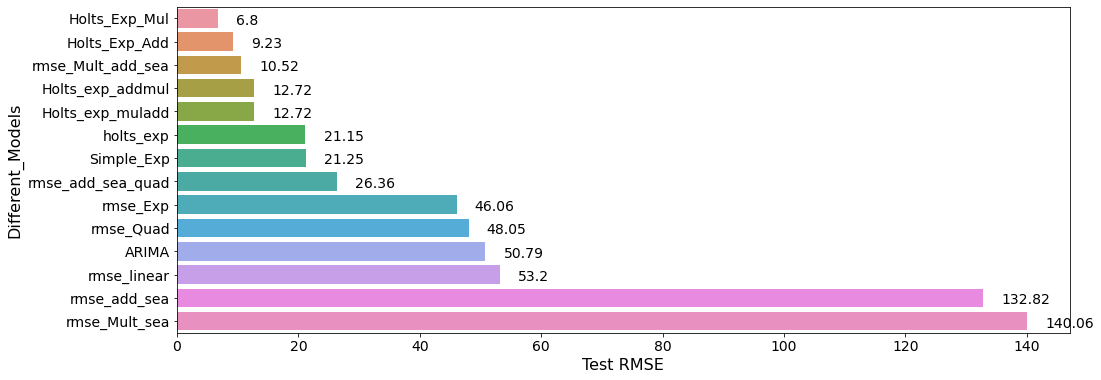

In [ ]:
f, axe = plt.subplots(1,1, figsize=(16,6))
sns.barplot(x='RMSE_Values', y='MODEL', data=tab_rmse, ax = axe)
axe.set_xlabel('Test RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(tab_rmse.RMSE_Values.values):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

*  Holts_exp_mul and Holts_exp_add are giving least RMSE out of all the models, and these will be useful for forecasting.



---
<center> THANK YOU


---


